In [1]:
using MKL, LinearAlgebra
using PhysicalUnits
using MoireIVC.LLHF
using MoireIVC.LLED
using MomentumED

In [2]:
using CairoMakie
CairoMakie.activate!()

In [3]:
system = LLHF.define_MoTe2system();
k_index = [
     0;  0;;
    +1;  0;;
     0; +1;;
    -1; +1;;
    -1;  0;;
     0; -1;;
    +1; -1;;
]
E_1 = 5.37meV
# Hmf[k,s,s',kD] c†_{k,s,kD} c_{k,s',kD};
function DiracCone(E_1=E_1, k_index=k_index)
    k_num = size(k_index,2)
    Hmf = zeros(ComplexF64, k_num, 2, 2, 2)
    if k_num == 1
        return Hmf
    elseif k_num == 7

        h1diag = 0.0
        h1offd = E_1
        for i in 1:6
            phase = ((i-1)/3-1/6)*pi
            Hmf[1+i,:,:,1] .=[h1diag;  h1offd*cis(phase);;  h1offd*cis(-phase); h1diag] 
            Hmf[1+i,:,:,2] .=[h1diag; -h1offd*cis(phase);; -h1offd*cis(-phase); h1diag] 
        end

        return Hmf
    else
        #error("k_num should be 0 or 7")
    end
end
Hmf=permutedims(DiracCone(), (3,4,2,1));

### 1. each Dirac point accompanied with 6 k-points

In [4]:
para1 = LLED_init(k_index[:,:], Hmf[:,:,:,:], system, 30, 1);
blocks1, block1_k1, block1_k2, k0number1 = 
    ED_momentum_block_division(para1, ED_mbslist(para1, (7,7));
    momentum_restriction = true, k1range=(-2,2), k2range=(-2,2));
length.(blocks1)

25-element Vector{Int64}:
  82016
 174224
 270848
 313088
 270848
 174224
 313088
 417424
 417424
 313088
      ⋮
 417424
 417424
 313088
 174224
 270848
 313088
 270848
 174224
  82016

In [5]:
int_onebodylist1 = ED_sortedScatteringList_onebody(para1);
int_twobodylist1 = ED_sortedScatteringList_twobody(para1);
length(int_onebodylist1), length(int_twobodylist1)

(18, 847)

##### eigenenergies of blocks with momentum close to zero

In [6]:
N_eigen = 8
eigenenergy = Matrix{Float64}(undef, N_eigen, length(blocks1));
for bn in eachindex(blocks1)
    println(bn, "\t", length(blocks1[bn]), "\t", "k=($(block1_k1[bn]), $(block1_k2[bn]))")
    vals = EDsolve(blocks1[bn], 
        int_onebodylist1, int_twobodylist1, N_eigen;
        showtime=true, converge_warning = false, tol = 1e-6
    )[1]
    if length(vals) < N_eigen
        eigenenergy[:,bn] .= vcat(vals, fill(NaN, N_eigen - length(vals)))
    else
        eigenenergy[:,bn] .= vals[1:N_eigen]
    end
end

1	82016	k=(-2, -2)
  4.091933 seconds (188.44 M allocations: 4.334 GiB, 29.82% gc time, 26.59% compilation time)
  3.672325 seconds (730.33 k allocations: 811.461 MiB, 6.42% gc time, 33.28% compilation time)
2	174224	k=(-2, -1)
  7.666456 seconds (403.97 M allocations: 9.696 GiB, 24.55% gc time)
  7.981018 seconds (6.15 k allocations: 1.922 GiB, 3.49% gc time)
3	270848	k=(-2, 0)
 12.702850 seconds (631.67 M allocations: 14.202 GiB, 21.29% gc time)
 12.322617 seconds (5.79 k allocations: 2.761 GiB, 5.50% gc time)
4	313088	k=(-2, 1)
 14.427380 seconds (731.20 M allocations: 17.543 GiB, 21.03% gc time)
 14.576475 seconds (5.58 k allocations: 3.164 GiB, 5.34% gc time)
5	270848	k=(-2, 2)
 11.644558 seconds (630.61 M allocations: 14.186 GiB, 20.87% gc time)
 12.365329 seconds (5.51 k allocations: 2.632 GiB, 5.20% gc time)
6	174224	k=(-1, -2)
  8.077770 seconds (403.84 M allocations: 9.694 GiB, 25.50% gc time)
  7.910627 seconds (6.14 k allocations: 1.922 GiB, 5.14% gc time)
7	313088	k=(-1, -

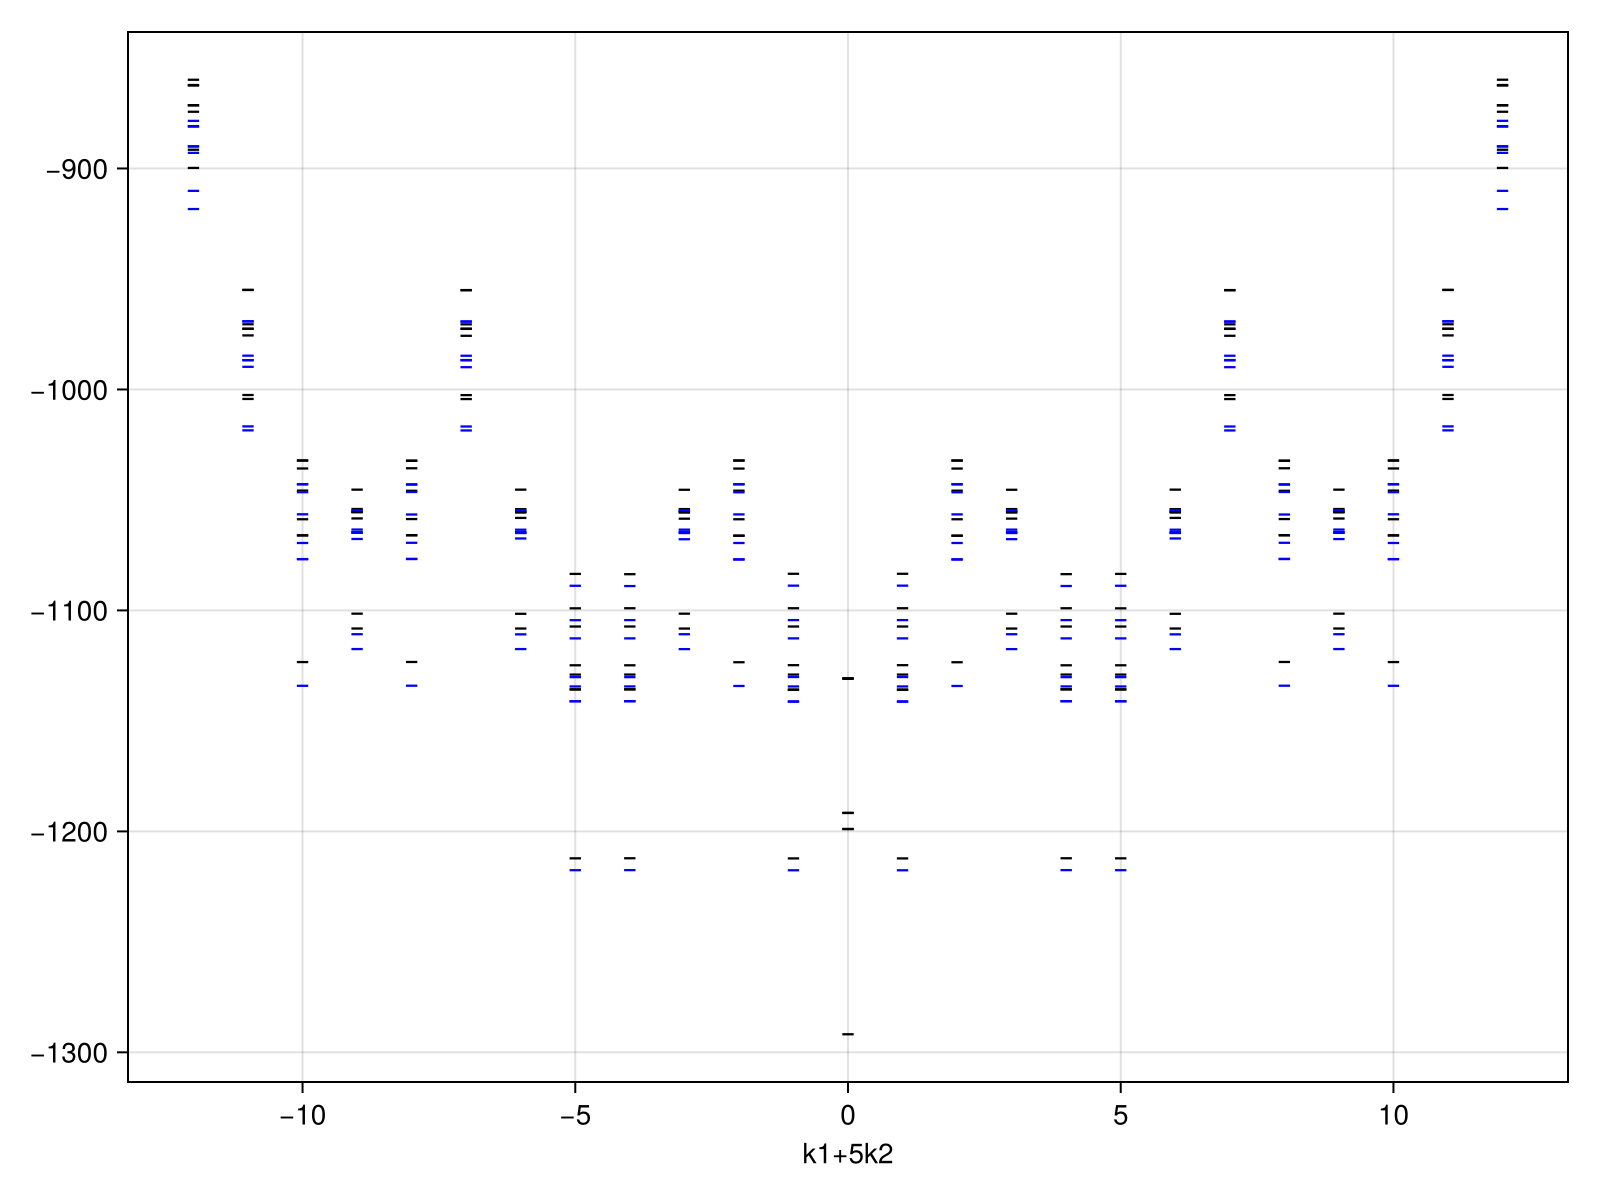

8-element Vector{Float64}:
 -1291.8162426300676
 -1198.9464774092505
 -1198.9130182857255
 -1191.6802815778647
 -1191.6137617048362
 -1130.9216957478056
 -1130.8436040368174
 -1130.7205439962165

In [12]:
# plot eigenenergies of blocks
eigEs = Figure(size = (800,600));
ax = Axis(eigEs[1,1],
    xlabel = "k1+5k2",
)
for bn in eachindex(blocks1)
    k1 = block1_k1[bn]; k2 = block1_k2[bn]
    xticknumber = k1 + 5k2
    energy_shift = E_1 * sqrt(k1^2 + k2^2 + k1*k2)
    for j in 1:N_eigen
        if !isnan(eigenenergy[j, bn])
            scatter!(ax, xticknumber, eigenenergy[j, bn];
                color=:black, marker=:hline
            )
            if xticknumber != 0
                scatter!(ax,xticknumber,eigenenergy[j,bn]-energy_shift;
                    color=:blue, marker=:hline
                )
            end
        end
    end
end
display(eigEs)
# ylims!(ax, -1279000, -1275000)
# display(eigEs)
eigenenergy[:,k0number1]


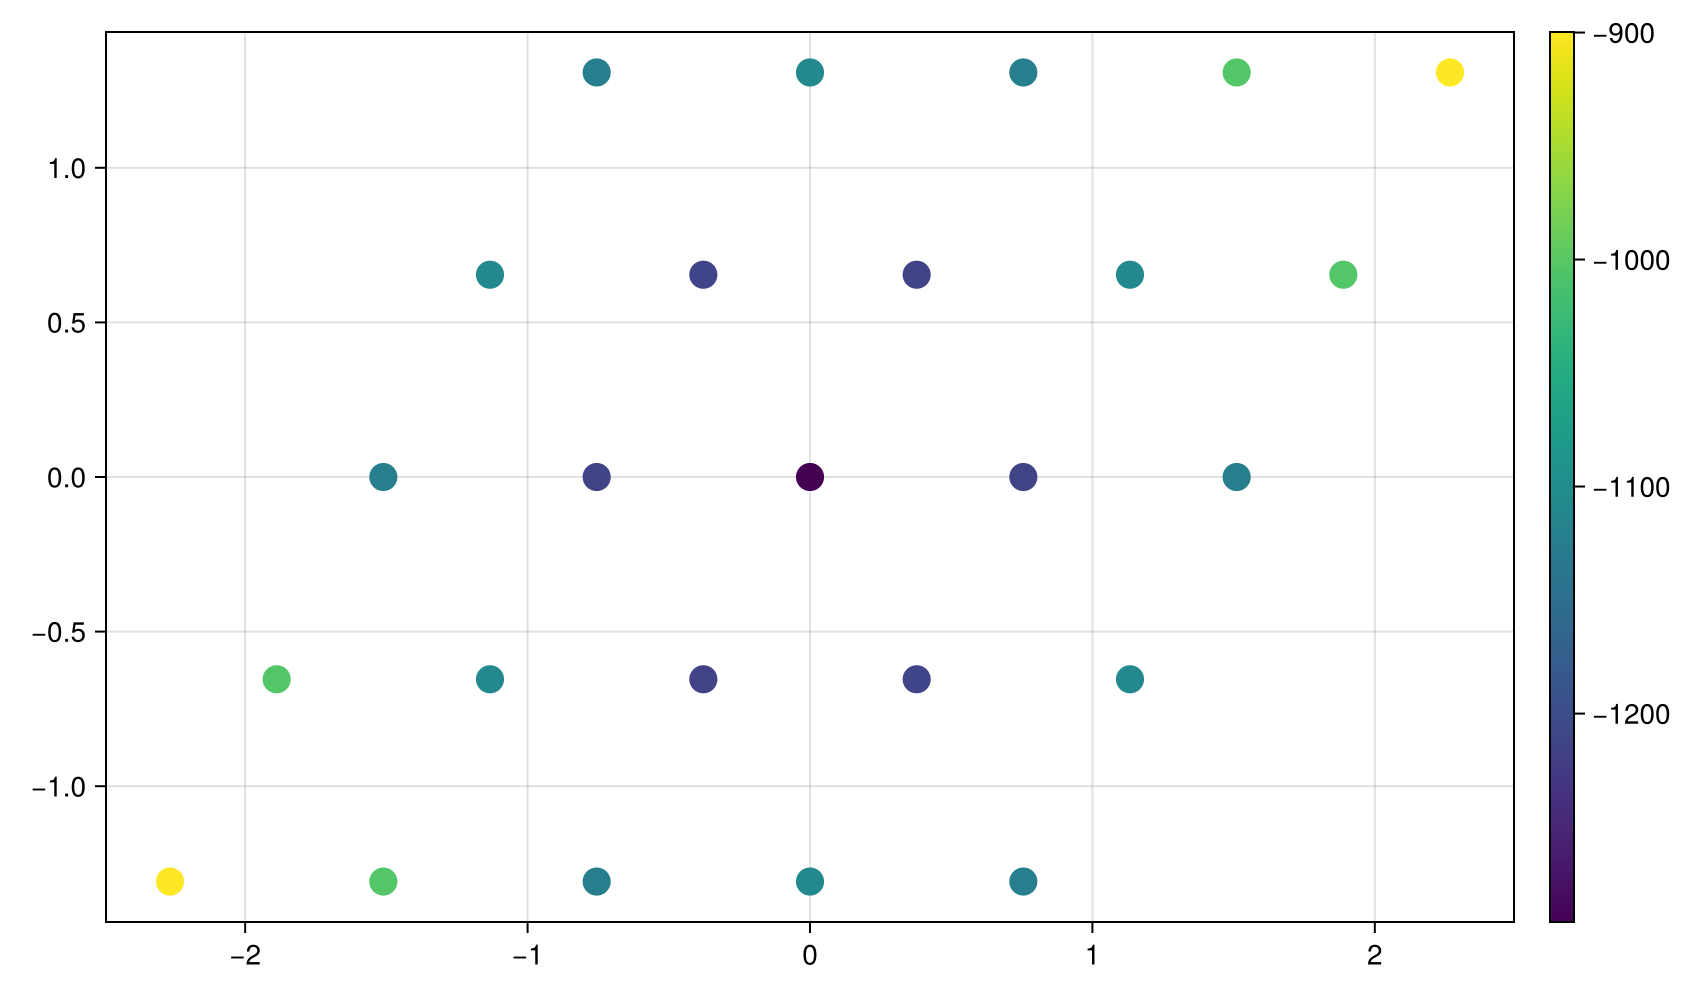

In [11]:
# ground state energy (color) vs. block momentum
lowest_E = Figure(size = (850,500));
ax_le = Axis(lowest_E[1,1])
Emin = Base.vec(eigenenergy[1,:])
block_kx = block1_k1 .* system.G1[1] + block1_k2 .* system.G2[1]
block_ky = block1_k1 .* system.G1[2] + block1_k2 .* system.G2[2]
sc = scatter!(ax_le, block_kx, block_ky;
    color = Emin, markersize = 20
)
Colorbar(lowest_E[1,2], sc)
lowest_E

##### calculate and analysis the k=0 eigenwavefunctions

In [14]:
@time vals_k0, vecs_k0 = EDsolve(blocks1[k0number1], 
        int_onebodylist1, int_twobodylist1, 10;
        showtime=true, converge_warning = false, tol = 1e-6);
@show vals_k0
dot(vecs_k0[1], vecs_k0[2])

 22.428043 seconds (1.13 G allocations: 26.158 GiB, 21.13% gc time, 0.00% compilation time)
 22.704609 seconds (6.15 k allocations: 5.153 GiB, 5.39% gc time)
 45.140345 seconds (1.13 G allocations: 31.312 GiB, 13.21% gc time, 0.02% compilation time)
vals_k0 = [-1291.8162426300692, -1198.9464774092482, -1198.913018285725, -1191.6802815778651, -1191.6137617048369, -1130.9216957478063, -1130.843604036818, -1130.7205439962163, -1130.7045803588837, -1117.4644139395105]


-4.9873299934333204e-17 - 3.7621815385247004e-17im

tr(onebodyRDM) / 14 = 0.9975290147093451 + 0.0im
maximum(abs.(onebodyRDM)) = 0.9758729433933472


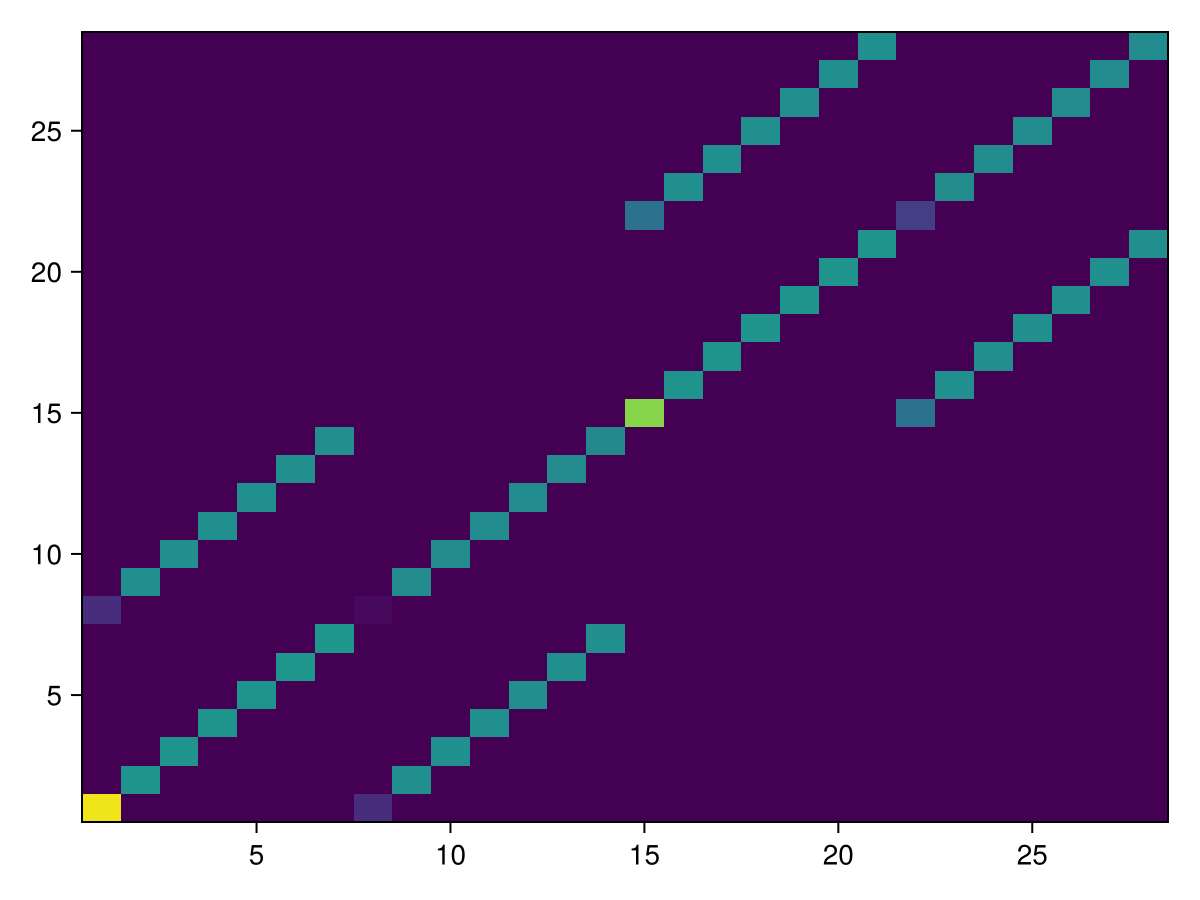

In [6]:
# one-body reduced density matrix
vec0 = vecs_k0[3]
onebodyRDM = LLED.one_body_reduced_density_matrix(vec0,blocks1[bn0_1])
@show tr(onebodyRDM)/14
@show maximum(abs.(onebodyRDM))
heatmap(abs.(onebodyRDM), colorrange = (0,1))

In [7]:
# reduced density matices and entanglement entropies
vec0 = vecs_k0[1]

# 1. Dirac point 1
using Combinatorics
iA1 = [0;7];
nA1 = (i_set -> sum(1 .<< i_set; init = 0)).(collect(powerset(iA1)));
RDM_1 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA1, iA1);
@show entropy1 = LLED.entanglement_entropy(RDM_1)
# 2. Dirac point 2
iA2 = [14;21];
nA2 = (i_set -> sum(1 .<< i_set; init = 0)).(collect(powerset(iA2)));
RDM_2 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA2, iA2);
@show entropy2 = LLED.entanglement_entropy(RDM_2)
# 3. two Dirac points
iA3 = [0;7;14;21];
nA3 = (i_set -> sum(1 .<< i_set; init = 0)).(collect(powerset(iA3)));
RDM_3 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA3, iA3);
@show entropy3 = LLED.entanglement_entropy(RDM_3)
# 4. all k-points near Dirac point 1
iA4 = collect(0:13);
nA4 = getfield.(LLED.mbslist_oneDiracCone(para1, 7), :n);
RDM_4 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA4, iA4);
@show entropy4 = LLED.entanglement_entropy(RDM_4)

entropy1 = LLED.entanglement_entropy(RDM_1) = 0.13913781362943067
entropy2 = LLED.entanglement_entropy(RDM_2) = 0.3914623408589726
entropy3 = LLED.entanglement_entropy(RDM_3) = 0.4944224299329179
entropy4 = LLED.entanglement_entropy(RDM_4) = 0.08432833915178345


0.08432833915178345

### 2. only the two Dirac points

In [16]:
para2 = LLED_init(k_index[:,[1]], Hmf[:,:,:,[1]], system, 30, 1);
blocks2 = 
ED_momentum_block_division(para2, ED_mbslist(para2, (1,1));
    momentum_restriction = false
)[1]
int_onebodylist2 = ED_sortedScatteringList_onebody(para2);
int_twobodylist2 = ED_sortedScatteringList_twobody(para2);
@show length(int_onebodylist2), length(int_twobodylist2)
int_twobodylist2

(length(int_onebodylist2), length(int_twobodylist2)) = (0, 7)


7-element Vector{MomentumED.Scattering{2}}:
 2-body scattering: c†_out (2, 1) c_in (1, 2), Amp = -38.62676575940485 + 0.0im
 2-body scattering: c†_out (3, 1) c_in (1, 3), Amp = 1.460259822156881 + 0.0im
 2-body scattering: c†_out (3, 2) c_in (2, 3), Amp = 30.897146006253518 + 0.0im
 2-body scattering: c†_out (3, 2) c_in (1, 4), Amp = 40.087025581561726 + 6.731613057885968e-31im
 2-body scattering: c†_out (4, 1) c_in (1, 4), Amp = 30.897146006253518 + 0.0im
 2-body scattering: c†_out (4, 2) c_in (2, 4), Amp = 1.460259822156881 + 0.0im
 2-body scattering: c†_out (4, 3) c_in (3, 4), Amp = -38.62676575940485 + 0.0im

In [19]:
@time vals_k0, vecs_k0 = EDsolve(blocks2[1], 
        int_onebodylist2, int_twobodylist2, 4;
        showtime=true, converge_warning = false, tol = 1e-6);
@show vals_k0
dot(vecs_k0[1], vecs_k0[2])

  0.005161 seconds (325 allocations: 19.500 KiB, 386.04% compilation time)


┌ Warning: Invariant subspace of dimension 3 (up to requested tolerance `tol = 1.0e-6`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 4`).
└ @ KrylovKit C:\Users\zoubo\.julia\packages\KrylovKit\MlUlm\src\eigsolve\lanczos.jl:42
┌ Warning: Lanczos eigsolve stopped without convergence after 1 iterations:
│ * 3 eigenvalues converged
│ * norm of residuals = (2.07e-15, 7.16e-16, 7.20e-17)
│ * number of operations = 3
└ @ KrylovKit C:\Users\zoubo\.julia\packages\KrylovKit\MlUlm\src\eigsolve\lanczos.jl:142


BoundsError: BoundsError: attempt to access 3-element Vector{Float64} at index [1:4]

In [9]:
vec0 = vecs2_k0[:,2];
iA = [0;1]; nA = [1;2];
RDM_A = LLED.reduced_density_matrix(vec0, blocks2[1], nA, iA);
entropy = LLED.entanglement_entropy(RDM_A)

0.0